## mounting Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries


In [3]:
!pip install noise

     |████████████████████████████████| 132 kB 5.1 MB/s 
  Created wheel for noise: filename=noise-1.2.2-cp37-cp37m-linux_x86_64.whl size=64380 sha256=2790298f5df253ca21e0f882639732461c7f6e697334e9f9e50d08ea755906cc
  Stored in directory: /root/.cache/pip/wheels/50/4f/1d/3e94460751c993553ba1a52b8e571ba6510701b4d0a68ffeea
Successfully built noise


In [6]:
from __future__ import division

from glob import glob
from IPython import display
from IPython.display import clear_output
from keras import backend as K
from keras import metrics
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers import Activation
from keras.layers import add
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import Conv2DTranspose, Conv3DTranspose, ConvLSTM2D, core
from keras.layers import Dense, Conv2D, Activation, BatchNormalization, Dropout, Flatten, Reshape
from keras.layers import Input, Dropout, Maximum, LayerNormalization, Minimum
from keras.layers import Input, Conv3D, MaxPooling3D, AveragePooling3D, ZeroPadding3D
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.convolutional import Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate, add
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.regularizers import l1_l2
from numpy import asarray
from numpy import savez_compressed
from numpy import vstack
from os import listdir
from PIL import Image
from scipy import ndimage
from skimage import data
from skimage import filters 
from skimage.io import imread, imshow, concatenate_images
from skimage.io import imsave
from skimage.transform import resize
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from time import time
from tqdm import tqdm
import cv2
import h5py
import keras
import keras.backend as K
import keras.models as models
import matplotlib.pyplot as plt
import nibabel as nib
import noise
import numpy as np
import os,random
import pandas as pd
import pickle
import random
import tensorflow as tf
import zipfile
K.clear_session()

## Loading training data for GAN

In [7]:
train_covid = np.load('.../train_covid_cropped.npy')
train_control = np.load('.../train_control_cropped.npy')

In [8]:
print(train_control.shape,train_covid.shape)

(226, 32, 128, 128) (664, 32, 128, 128)


In [9]:
train_covid = np.reshape(train_covid,(664,32,128,128,1))
print(train_covid.shape)

train_control = np.reshape(train_control,(226,32,128,128,1))
print(train_control.shape)

(664, 32, 128, 128, 1)
(226, 32, 128, 128, 1)


## Model

In [10]:
def generator_model(inputs,z, coef_filt):
    n = 1
    f_si = 3
    conv11 = Conv3D(8*n, (f_si, f_si, f_si), padding='same')(inputs) 
    conv11 = LeakyReLU(alpha=0.3)(conv11)
    conc11 = concatenate([inputs, conv11], axis=4)

    conv12 = Conv3D(8*n, (f_si, f_si, f_si), padding='same')(conc11)
    conv12 = LeakyReLU(alpha=0.3)(conv12)

    conc12 = concatenate([inputs, conv12], axis=4)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conc12)

    conv21 = Conv3D(16*n, (f_si, f_si, f_si), padding='same')(pool1)
    conv21 = LeakyReLU(alpha=0.3)(conv21)

    conc21 = concatenate([pool1, conv21], axis=4)
    conv22 = Conv3D(16*n, (f_si, f_si, f_si), padding='same')(conc21)
    conv22 = LeakyReLU(alpha=0.3)(conv22)

    conc22 = concatenate([pool1, conv22], axis=4)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conc22)

    conv31 = Conv3D(32*n, (f_si, f_si, f_si), padding='same')(pool2)
    conv31 = LeakyReLU(alpha=0.3)(conv31)

    conc31 = concatenate([pool2, conv31], axis=4)
    conv32 = Conv3D(32*n, (f_si, f_si, f_si), padding='same')(conc31)
    conv32 = LeakyReLU(alpha=0.3)(conv32)

    conc32 = concatenate([pool2, conv32], axis=4)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conc32)

    conv41 = Conv3D(64*n, (f_si, f_si, f_si), padding='same')(pool3)
    conv41 = LeakyReLU(alpha=0.3)(conv41)

    conc41 = concatenate([pool3, conv41], axis=4)
    conv42 = Conv3D(64*n, (f_si, f_si, f_si), padding='same')(conc41)
    conv42 = LeakyReLU(alpha=0.3)(conv42)
    
    conc42 = concatenate([pool3, conv42], axis=4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conc42)

    conv51 = Conv3D(128*n, (f_si, f_si, f_si), padding='same')(pool4)
    conv51 = LeakyReLU(alpha=0.3)(conv51)

    conc51 = concatenate([pool4, conv51], axis=4,name='HI')
    
    conc51_1 = concatenate([conc51, z], axis=4)
    
    conv51_1_1 = Conv3D(83, (1, 1, 1), padding='same')(conc51_1)
    conv51_1_1 = LeakyReLU(alpha=0.3)(conv51_1_1)

    conv51_1_2 = Conv3D(83, (3, 3, 3), padding='same')(conc51_1)
    conv51_1_2 = LeakyReLU(alpha=0.3)(conv51_1_2)

    conv51_1_3 = Conv3D(83, (5, 5, 5), padding='same')(conc51_1)
    conv51_1_3 = LeakyReLU(alpha=0.3)(conv51_1_3)

    conc51_2 = concatenate([conv51_1_1, conv51_1_2, conv51_1_3], axis=4,name="conection")


    conc51_3 = add([conc51,conc51_2])

    conv52 = Conv3D(128*n, (f_si, f_si, f_si), padding='same')(conc51_3)
    conv52 = LeakyReLU(alpha=0.3)(conv52)
    
    conc52 = concatenate([pool4, conv52], axis=4)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc52), conc42], axis=4)
    conv61 = Conv3D(64*n, (f_si, f_si, f_si), padding='same')(up6)
    conv61 = LeakyReLU(alpha=0.3)(conv61)

    conc61 = concatenate([up6, conv61], axis=4)
    conv62 = Conv3D(64*n, (f_si, f_si, f_si), padding='same')(conc61)
    conv62 = LeakyReLU(alpha=0.3)(conv62)

    conc62 = concatenate([up6, conv62], axis=4)


    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc62), conv32], axis=4)
    conv71 = Conv3D(32*n, (f_si, f_si, f_si), padding='same')(up7)
    conv71 = LeakyReLU(alpha=0.3)(conv71)

    conc71 = concatenate([up7, conv71], axis=4)
    conv72 = Conv3D(32*n, (f_si, f_si, f_si), padding='same')(conc71)
    conv72 = LeakyReLU(alpha=0.3)(conv72)

    conc72 = concatenate([up7, conv72], axis=4)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc72), conv22], axis=4)
    conv81 = Conv3D(16*n, (f_si, f_si, f_si), padding='same')(up8)
    conv81 = LeakyReLU(alpha=0.3)(conv81)   

    conc81 = concatenate([up8, conv81], axis=4)
    conv82 = Conv3D(16*n, (f_si, f_si, f_si), padding='same')(conc81)
    conv82 = LeakyReLU(alpha=0.3)(conv82)   
    
    conc82 = concatenate([up8, conv82], axis=4)
    print(Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc82).shape,conv12.shape)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc82), conv12], axis=4)
    conv91 = Conv3D(8*n, (f_si, f_si, f_si), padding='same')(up9)
    conv91 = LeakyReLU(alpha=0.3)(conv91)   

    conc91 = concatenate([up9, conv91], axis=4)
    conv92 = Conv3D(8*n, (f_si, f_si, f_si), padding='same')(conc91)
    conv92 = LeakyReLU(alpha=0.3)(conv92)   
    conc92 = concatenate([up9, conv92], axis=4)
    conv10 = Conv3D(1, (1, 1, 1),activation='relu')(conc92)
    return conv10

In [11]:
def discriminator_model(inputs):
    x = layers.Conv3D(filters=16, kernel_size=3)(inputs)
    x = Activation('relu')(x)  
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=32, kernel_size=3)(inputs)
    x = Activation('relu')(x)   
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3)(x)
    x = Activation('relu')(x)   
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3)(x)
    x = Activation('relu')(x)   
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=32)(x)
    x = Activation('relu')(x)       
    x = layers.Dropout(0.5)(x)    
    x = layers.Dense(units=16)(x)
    x = Activation('relu')(x)     
    x = layers.Dropout(0.5)(x)    
    x = layers.Dense(units=8)(x)
    x = Activation('relu')(x)     
    outputs = layers.Dense(units=2, activation="softmax")(x)
    return outputs

## Preparing for training

In [12]:
def make_trainable(model, trainable):
    """ Helper to freeze / unfreeze a model """
    model.trainable = trainable
    for l in model.layers:
        l.trainable = trainable

In [13]:

input_depth=32
input_rows=128
input_columns=128

print('\nGenerator')
input_img = Input(shape=(input_depth, input_rows, input_columns, 1))
g_input = Input(shape=[2,8,8,10])
n =  Input(shape=(32,128,128,1))
g_output = generator_model(input_img,g_input,n)
generator = Model(inputs = [input_img,g_input,n], outputs=  g_output)
print(generator.summary())

print('\nDiscriminator')
d_input = keras.Input((32, 128, 128,  1))
inputs = keras.Input((input_depth,input_rows, input_columns,  1))
d_output = discriminator_model(inputs)
discriminator = Model(inputs, d_output)
print(discriminator.summary())

d_opt = Adam(learning_rate=1e-3)
discriminator.compile(loss='mse', optimizer=d_opt, metrics=['accuracy'])


Generator
(None, 32, 128, 128, 128) (None, 32, 128, 128, 8)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 12  0           []                               
                                8, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 32, 128, 128  224         ['input_1[0][0]']                
                                , 8)                                                              
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 128, 128  0           ['conv3d[0][0]']                 
                                ,

In [14]:
ntrain = 5
ntest = 5

trainidx = random.sample(range(0,200), ntrain)
XTr = train_control[trainidx,:,:,:,:]

testidx = random.sample(range(200,226), ntest)
XTe = train_control[testidx,:,:,:,:]

trainidx = random.sample(range(0,650), ntrain)
GXTr = train_covid[trainidx,:,:,:,:]

testidx = random.sample(range(650,664), ntest)
GXTe = train_covid[testidx,:,:,:,:]


noise_gen_train = np.random.uniform(-0.5,0.5,size=[GXTr.shape[0],2,8,8,10])
noise_gen_test = np.random.uniform(-0.5,0.5,size=[GXTe.shape[0],2,8,8,10])

n = np.ones((5,32,128,128,1))
generated_images_train = generator.predict([GXTr,noise_gen_train,n])
generated_images_test = generator.predict([GXTe,noise_gen_test,n])

Xtr = np.concatenate((XTr, generated_images_train))
n = XTr.shape[0]
ytr = np.zeros([2*n,2])
ytr[:n,1] = 1
ytr[n:,0] = 1

Xte = np.concatenate((XTe, generated_images_test))
n = XTe.shape[0]
yte = np.zeros([2*n,2])
yte[:n,1] = 1
yte[n:,0] = 1

make_trainable(discriminator,True)
print(Xtr.shape)
print(ytr.shape)
print(Xte.shape)
print(yte.shape)

discriminator.fit(Xtr, ytr, batch_size=5,epochs=1,verbose=1,validation_data=(Xte, yte))

(10, 32, 128, 128, 1)
(10, 2)
(10, 32, 128, 128, 1)
(10, 2)
2/2 [==============================] - 1s 326ms/step - loss: 0.2618 - accuracy: 0.5000 - val_loss: 0.2562 - val_accuracy: 0.5000


In [15]:
def plot_loss(losses):
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"][:], label='discriminitive loss')
    plt.plot(losses["g"][:], label='generative loss')
    plt.legend()
    plt.show()
        
def plot_gen(n_ex=8,dim=(2,8), figsize=(10,10),coef_filt=1):
    for num in [661,662]:
        noise = train_covid[num:num+1,:,:,:,:]
        noise_gen_test = np.random.uniform(-0.5,0.5,size=[1,2,8,8,10])
        n = coef_filt*np.ones((1,32,128,128,1))
        generated_images = generator.predict([noise,noise_gen_test,n])
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):

            n = int(20)
            img = generated_images[i,n,:,:,0]  

            plt.subplot(1,3,1)
            plt.imshow(noise[i,n,:,:,0])
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.imshow(img)
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(noise[i,n,:,:,0] - img)
            plt.axis('off')

        plt.tight_layout()
        plt.show() 
    
losses = {"d":[], "g":[]}         

In [16]:
def GAN_gen(my_data,my_model):
    '''
    size in and out = 1,32,128,128,1
    '''
    # noise_gen_Trr = per_noise_gen(batch_size=1)
    noise_gen_Trr = np.random.uniform(-0.5,0.5,size=[1,2,8,8,10])

    randomness  = 1*np.random.rand(1,1)[0][0]
    n = randomness*np.ones((1,32,128,128,1))
    my_out = generator.predict([my_data,noise_gen_Trr,n])
    return my_out

In [17]:
def prediction_GAN():
    gan_out = np.zeros((1*train_covid.shape[0],train_covid.shape[1],train_covid.shape[2],train_covid.shape[3],1)) # 4: four models

    for i in tqdm(range(train_covid.shape[0])):
        if(i<664):
            gan_out[i:i+1] = GAN_gen(train_covid[i:i+1],generator_model)
        else:
            gan_out[i:i+1] = train_covid[i:i+1]
    return gan_out

In [19]:
ntrain = 5
# Set up GAN by stacking the discriminator on top of the generator
print('\nGenerative Adversarial Network')
input_depth=32
input_rows=128
input_columns=128
#Encoder
gan_input = Input(shape=(input_depth, input_rows, input_columns, 1))
g_input = Input(shape=[2,8,8,10])

n =  Input(shape=(32,128,128,1))
gan_output = discriminator(generator([gan_input,g_input,n]))
GAN = Model(inputs = [gan_input,g_input,n], outputs = gan_output)
print(GAN.summary())

initial_learning_rate = 0.00005

g_opt = Adam(learning_rate= initial_learning_rate)

GAN.compile(loss='mse', optimizer=g_opt)
generator.compile(loss='mse', optimizer=g_opt)



Generative Adversarial Network
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 128, 12  0           []                               
                                8, 1)]                                                            
                                                                                                  
 input_10 (InputLayer)          [(None, 2, 8, 8, 10  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 32, 128, 12  0           []                               
                                8, 1)]                      


## Training


In [20]:
def add_noise(input_array):
    shape = (128,128)
    scale = np.random.randint(10,30)
    octaves = 10
    persistence = 0.01*np.random.randint(-50,50)
    lacunarity = 2.0
    seed = np.random.randint(0,1000)
    world = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            world[i][j] = noise.pnoise2(i/scale, 
                                        j/scale, 
                                        octaves=octaves, 
                                        persistence=persistence, 
                                        lacunarity=lacunarity, 
                                        repeatx=140, 
                                        repeaty=140, 
                                        base=seed)
    return cv2.addWeighted(input_array, 1, world, 1, 0) 

def add_noise_3d(input_array):
    # input size: 5,32,128,128,1
    output_array = input_array.copy()
    my_rand = random.sample(range(0,32), 8)
    for i in range(input_array.shape[0]):
        my_rand = random.sample(range(0,32), 8)
        for j in my_rand:
            output_array[i,j,:,:,0] = add_noise(input_array[i,j,:,:,0])
    return output_array

In [21]:
def train_for_n(nb_epoch, plt_frq,BATCH_SIZE,con_num,cov_num,ae_rate = 4,yorno=0):
    for e in (range(nb_epoch)):  
        D_losss = [] 
        A_losss = [] 
        if (e%ae_rate == 0 ):
            trainidx = random.sample(range(0,con_num), BATCH_SIZE)
            clean_gen = train_control[trainidx,:,:,:,:]
            # clean_gen2 = per_noise_gen(clean_gen)
            clean_gen2 = add_noise_3d(clean_gen)
            noise_gen_Trr = np.random.uniform(-0.5,0.5,size=[BATCH_SIZE,2,8,8,10])
            n = np.ones((BATCH_SIZE,32,128,128,1))
            generator.train_on_batch([clean_gen2,noise_gen_Trr,n], clean_gen)
       
        trainidx = random.sample(range(0,cov_num), BATCH_SIZE)
        noise_gen = train_covid[trainidx,:,:,:,:]
        noise_gen_Trr = np.random.uniform(-0.5,0.5,size=[BATCH_SIZE,2,8,8,10])
        n = np.ones((BATCH_SIZE,32,128,128,1))
        generated_images = generator.predict([noise_gen,noise_gen_Trr,n])
        
        # Train discriminator on generated images
        trainidx = random.sample(range(0,con_num), BATCH_SIZE)
        image_batch = train_control[trainidx,:,:,:,:]
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        make_trainable(discriminator,True)
        # print(y.shape)
        d_loss  = discriminator.train_on_batch(X,y)
        a,b = discriminator.evaluate(X,y,verbose=0)
        D_losss.append(a)
        A_losss.append(b)
        losses["d"].append(d_loss[0])

        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr_dc = np.random.uniform(-0.5,0.5,size=[BATCH_SIZE,2,8,8,10])

        noise_tr = random.sample(range(0,cov_num), BATCH_SIZE)
        
        noise_tr = train_covid[noise_tr,:,:,:,:]
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1

        make_trainable(discriminator,False)
        n = 1*np.ones((BATCH_SIZE,32,128,128,1))

        g_loss = GAN.train_on_batch([noise_tr,noise_tr_dc,n], y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            generator.save('.../generator_model', save_format='h5')
            discriminator.save('.../discriminator_model', save_format='h5')
            clear_output()
            plot_loss(losses)
            plot_gen()

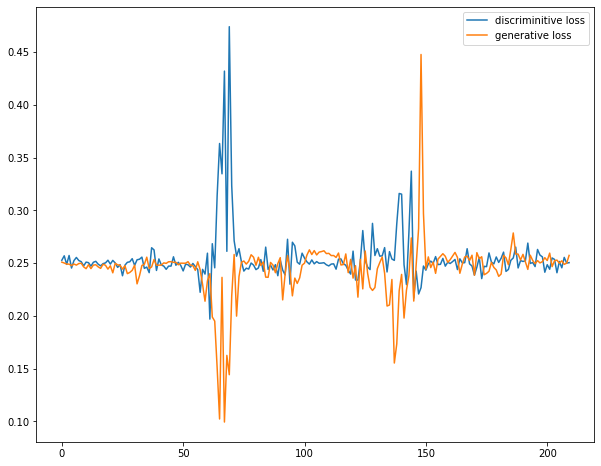

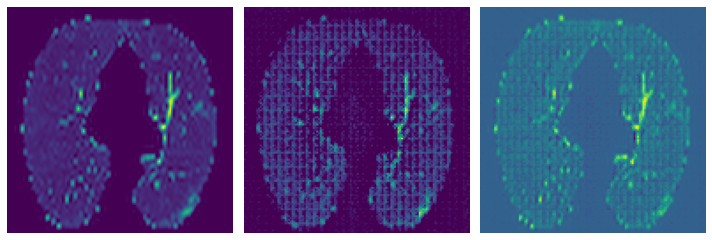

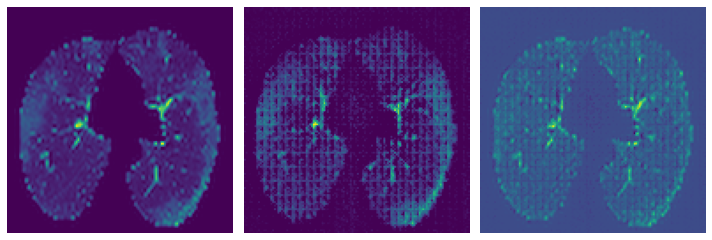

KeyboardInterrupt: ignored

In [ ]:
train_for_n(nb_epoch=10000,
            plt_frq=10,
            BATCH_SIZE=5,
            con_num=220,
            cov_num=660,
            ae_rate=1)

## Final

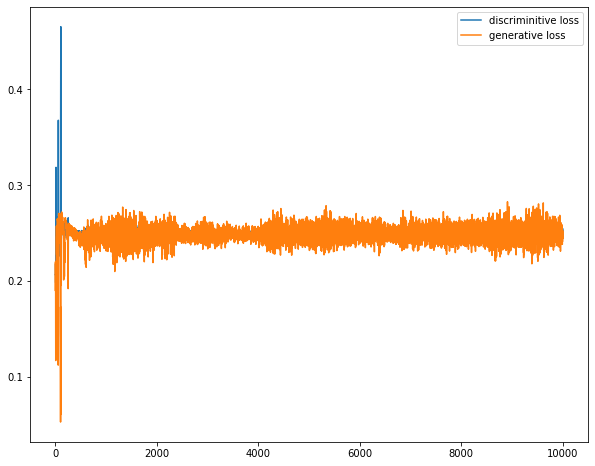

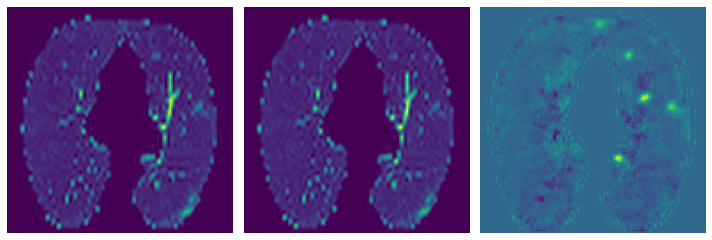

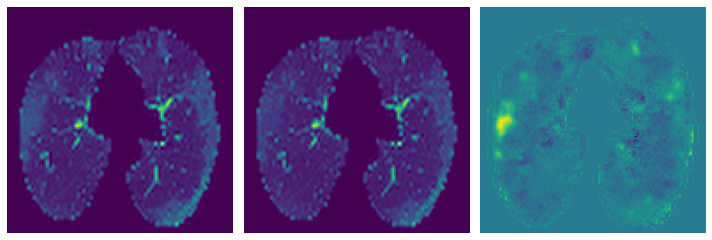

In [ ]:
train_for_n(nb_epoch=10000,
            plt_frq=1,
            BATCH_SIZE=5,
            con_num=220,
            cov_num=660,
            ae_rate=1)

# Visualization of some examples

In [ ]:
def reshaping_bcdunet(inp):
    '''
    size = b,32,128,128,1
    out = b*32,128,128,1
    '''
    output = np.zeros((0,128,128,1))
    for i in tqdm(range(inp.shape[0])):
        inp[i,:,:,:,:] = (inp[i,:,:,:,:] - np.amin(inp[i,:,:,:,:]))/(np.max(inp[i,:,:,:,:]) - np.min(inp[i,:,:,:,:]))
        output = np.append(output,inp[i,:,:,:,:],axis = 0)
    return output

In [ ]:
generator = keras.models.load_model('.../generator_model')

In [ ]:
def GAN_gen(my_data,my_model):
    '''
    size in and out = 1,32,128,128,1
    '''
    # noise_gen_Trr = per_noise_gen(batch_size=1)
    noise_gen_Trr = np.random.uniform(-0.5,0.5,size=[1,2,8,8,10])

    randomness  = 1*np.random.rand(1,1)[0][0]
    n = randomness*np.ones((1,32,128,128,1))
    my_out = generator.predict([my_data,noise_gen_Trr,n])
    return my_out

In [ ]:
def prediction_GAN():
    gan_out = np.zeros((1*train_covid.shape[0],train_covid.shape[1],train_covid.shape[2],train_covid.shape[3],1)) # 4: four models

    for i in tqdm(range(train_covid.shape[0])):
        if(i<664):
            gan_out[i:i+1] = GAN_gen(train_covid[i:i+1],generator_model)
        else:
            gan_out[i:i+1] = train_covid[i:i+1]
    return gan_out

In [ ]:
dis1 = reshaping_bcdunet(train_covid)
gan_out = prediction_GAN()
out = reshaping_bcdunet(gan_out)

100%|██████████| 664/664 [03:36<00:00,  3.06it/s]


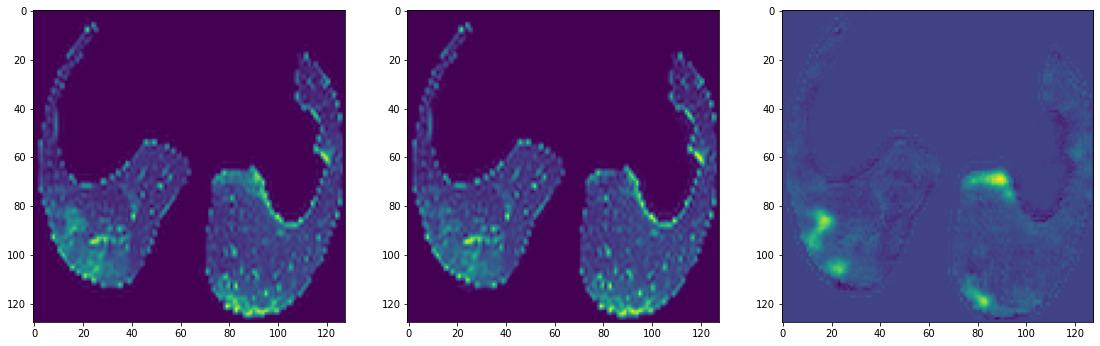

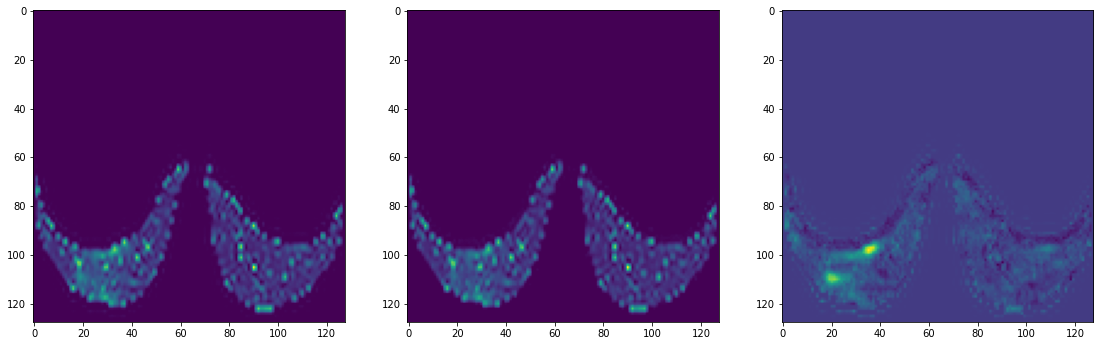

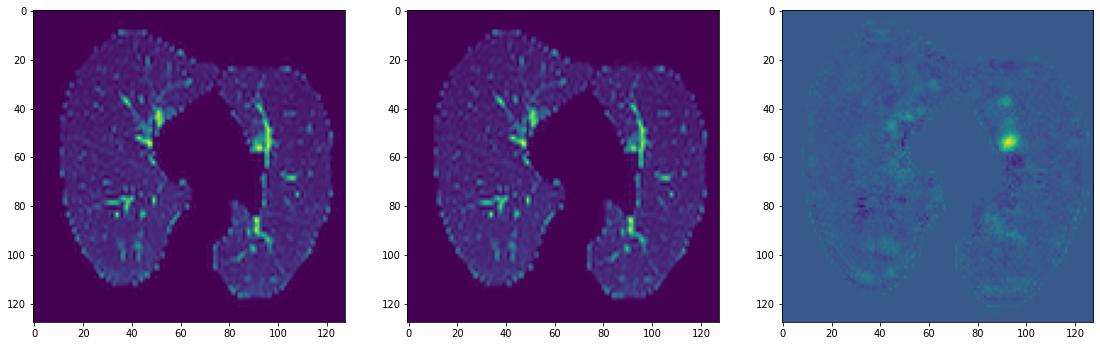

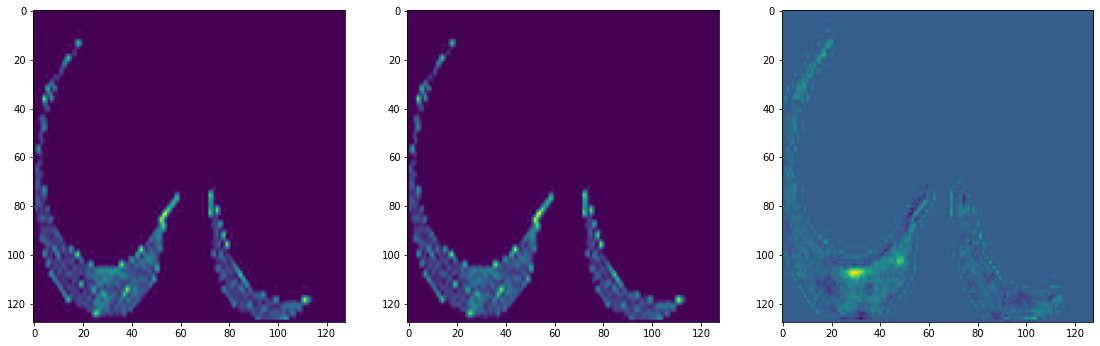

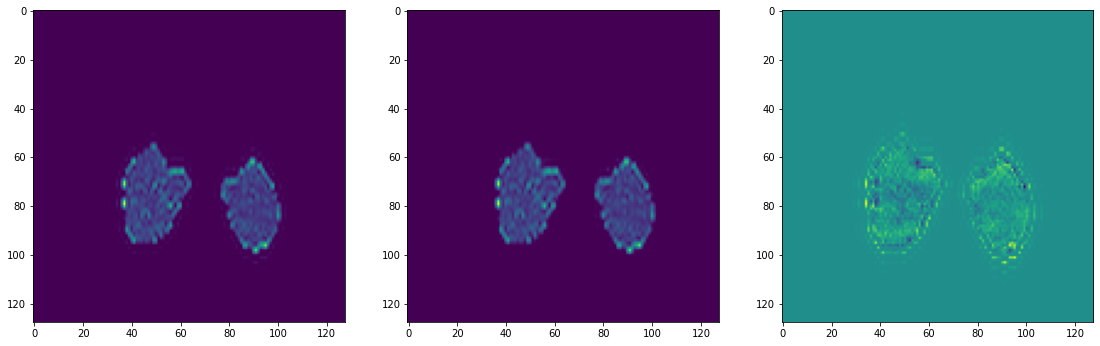

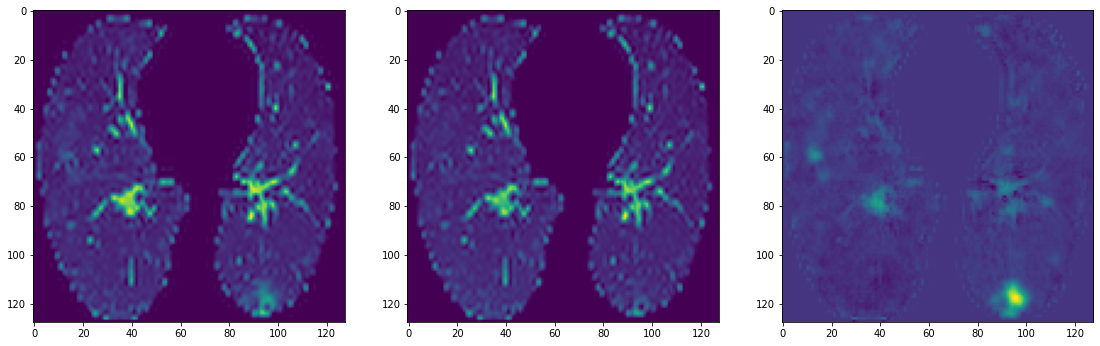

In [ ]:
# we select some samples to show some different slices from different cases
for i in [20744,2150,18803,20964, 8300,4591]:
    plt.figure(figsize=(19,19))
    plt.subplot(131)
    plt.imshow(dis1[i,:,:,0])

    plt.subplot(132)
    plt.imshow(out[i,:,:,0])

    plt.subplot(133)
    plt.imshow(dis1[i,:,:,0] - out[i,:,:,0])

In [ ]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl